In [ ]:
# Homework 1: Decision Trees
#
# This python notebook is for Homework 1 of CS6350 at the University of Utah. It covers Decision Trees and runs a basic ID3 algorithm.
# To run the decision tree algorithm the gain and entropies are first calculated to determine which attributes in the dataset are most
# relevant to split the data. Then root nodes are created, leaf nodes are found, and the tree is grown.
#
# Then the decision trees are tested to check and see if they are accurate.
#
# @author: Scott Merkley
# @version: September 03, 2024

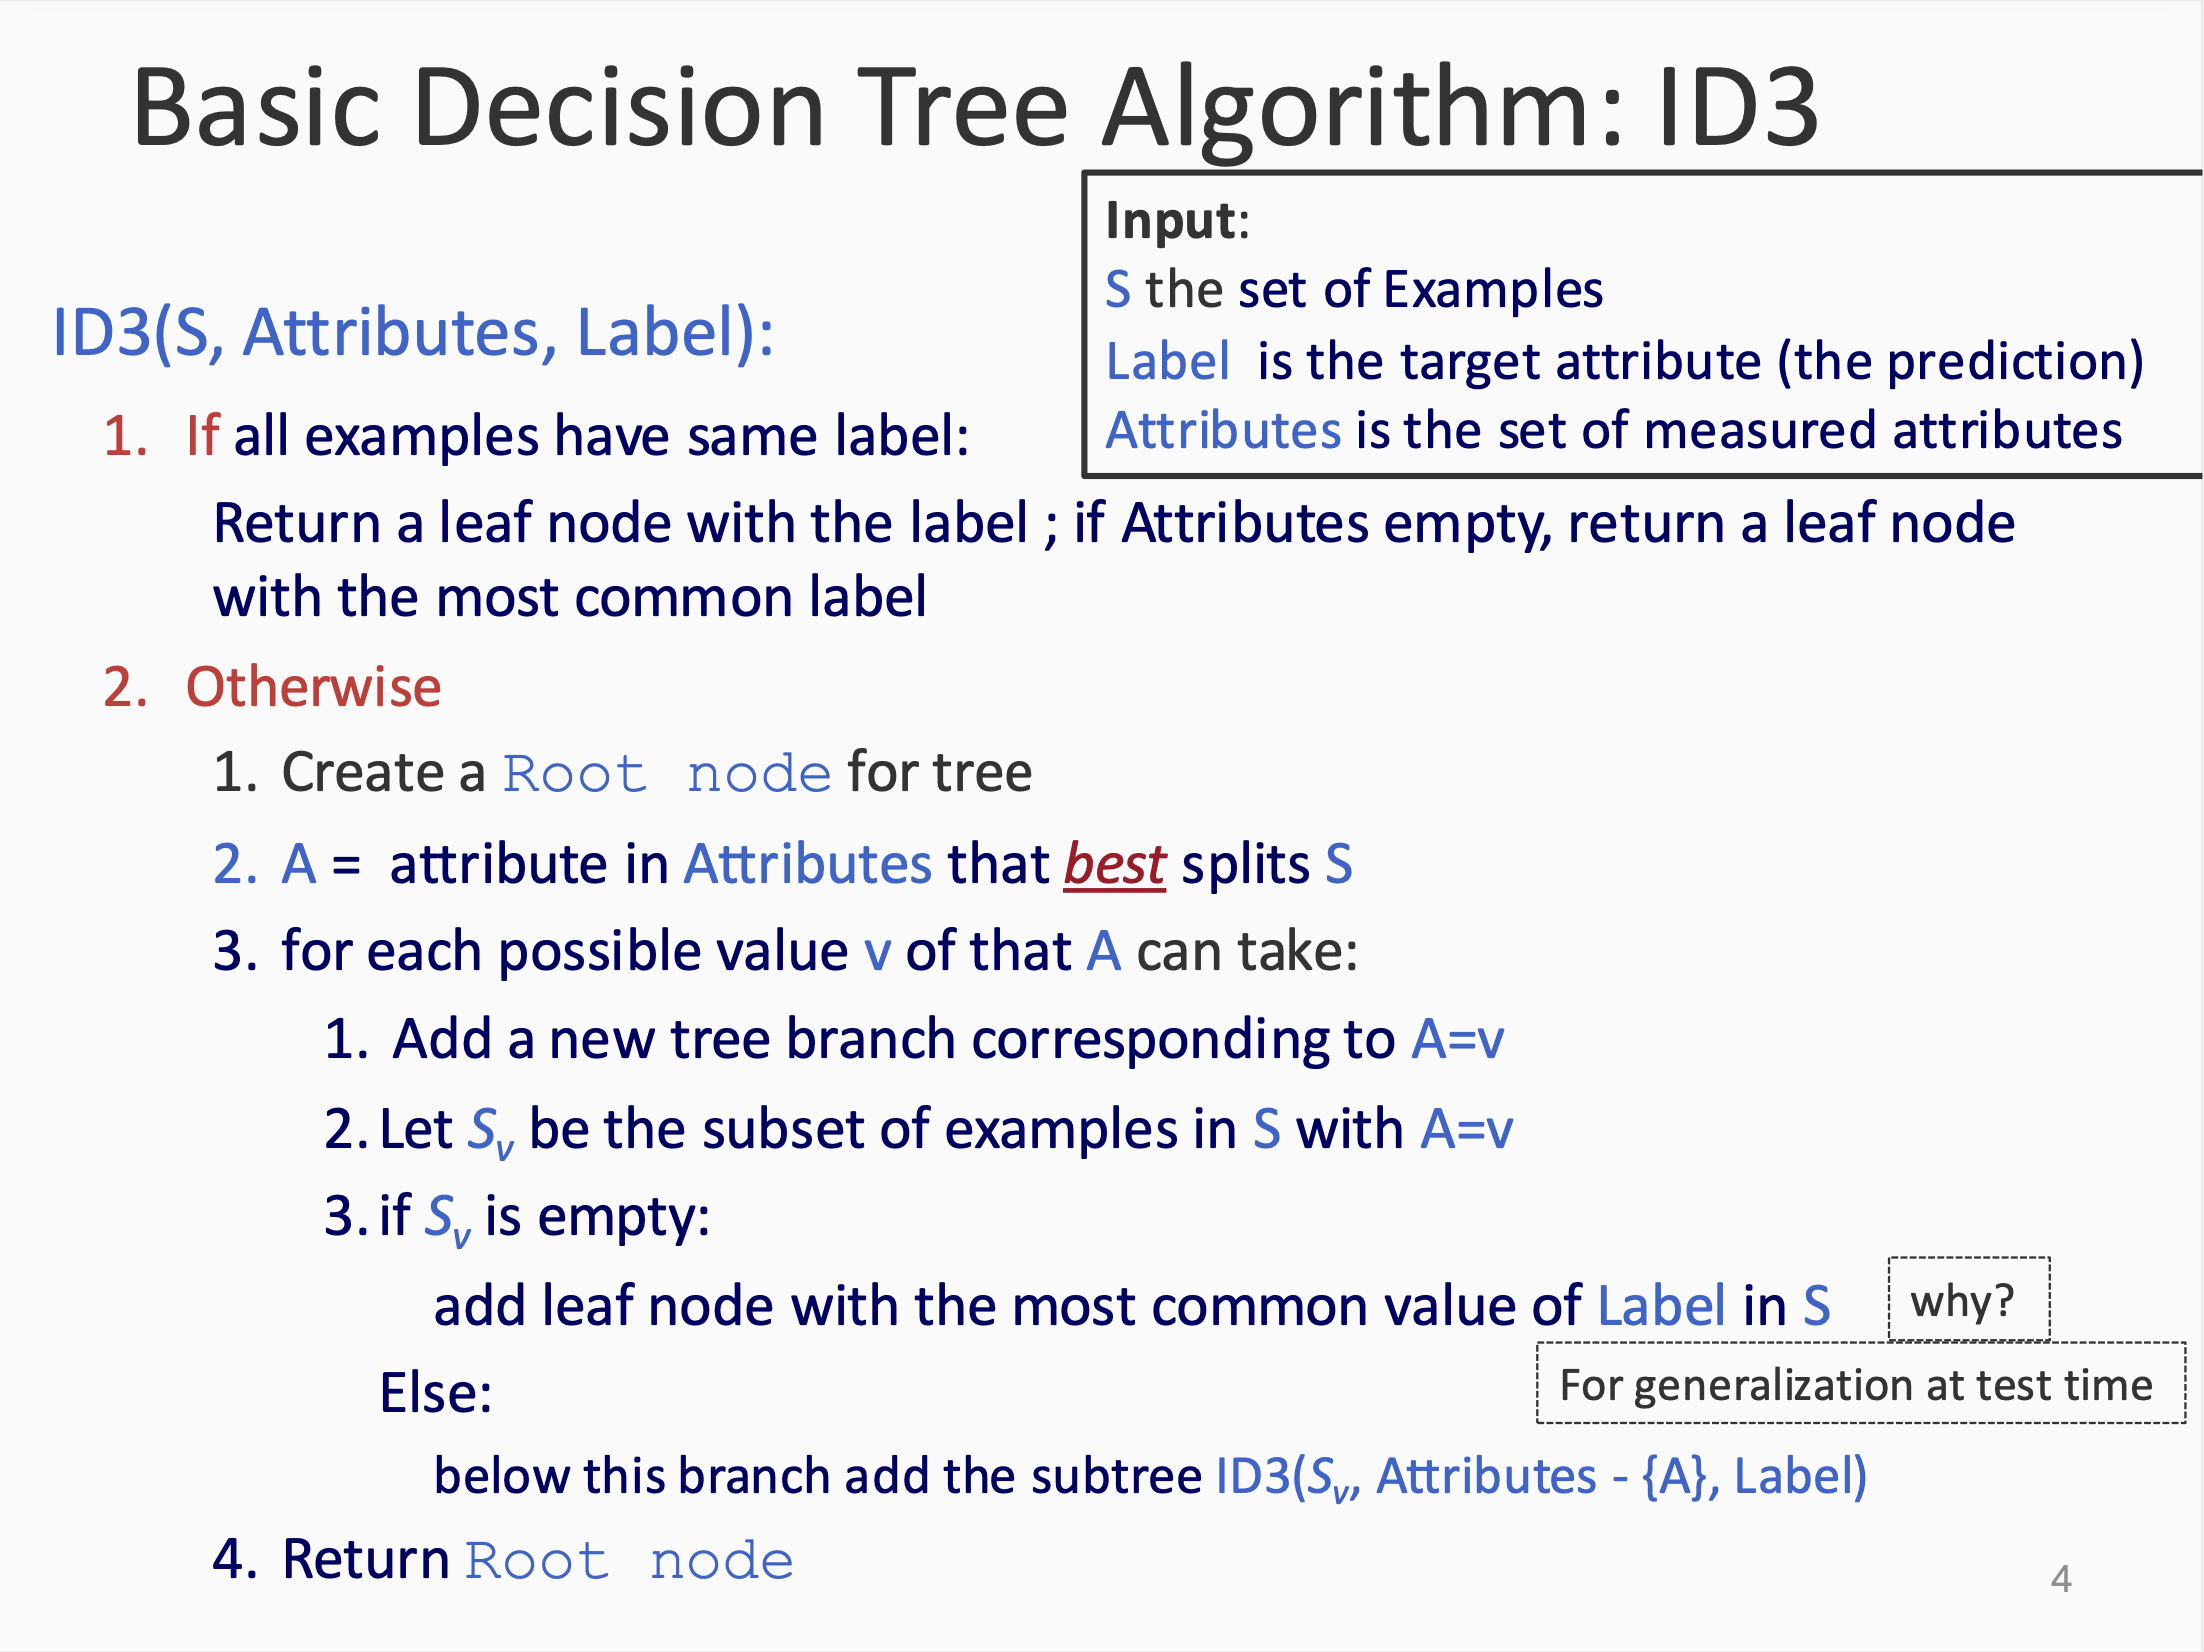

# **Import Libraries**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

# **Gain Functions, Node Class, and ID3 Algorithm**

In [2]:
####################################################################################################################################################################################################################################
#                                                                                                                                                                                                                                  #
#                                                                                                 Entropy and Gain Functions                                                                                                       #
#                                                                                                                                                                                                                                  #
####################################################################################################################################################################################################################################

# This function takes in a positive and negative numbers for one attribute of a set, the total
# of their entries and calculates the entropy for that single array.
#
def Calculate_Single_Entropy(arr):
  tot = np.sum(arr)
  H_entropy = 0
  for val in arr:
    if val == 0:
      return 0
    else:
      H_entropy += -(val / tot) * math.log2(val / tot)
  return H_entropy


# This function takes in the positive and negative numbers of chances that the attribute has,
# calculates, and returns the entropy.
#
def Entropy(entropy_arr):

  if not isinstance(entropy_arr, np.ndarray):
    entropy_arr = np.array(entropy_arr)

  try:
    if entropy_arr.shape[1] > 1:
      H_entropy = 0
      for arr in entropy_arr:
            H_entropy += np.sum(arr) / np.sum(entropy_arr) * Calculate_Single_Entropy(arr)
      return H_entropy
  except:
      return Calculate_Single_Entropy(entropy_arr)


# This function calculates the gain from given positive and negative values in an array so
# that the decision tree can decide which attribute to use next.
#
# Format of 'entropies':
#
#    [[pos, neg],     First attribute with pos, neg values
#     [pos, neg],     Second attribute with pos, neg values
#     [pos, neg],
#        ...
#     [pos, neg]]     Total pos, neg of system
#
def Gain(df):

  # Check if df is a df, if not, make it a df
  entropies = []
  for col_name in df.columns:
    col_entropy = []
    for val in pd.crosstab(df[col_name], df[df.columns[-1]]).values:
        col_entropy.append(val)

    if col_name == df.columns[-1]:
      # You need to collate these values so that they are in the form [9, 5] instead of [9, 0], [0, 5]
      col_entropy = [max(elements) for elements in zip(*col_entropy)]

    # I want to calculate the entropy for each column here
    entropies.append(Entropy(col_entropy))

  # Calculating the Gain
  entropies = entropies[-1] - entropies
  entropies = entropies[:-1]
  return np.array(entropies)



# This function calculates the Majority Error of a given dataframe, it assumes that the first columns are the attributes and the last column is the labels.
# It returns an array of errors to find the majority from.
#
def Majority_Error(df):
  errors = []
  for col_name in df.columns[:-1]:
    errors.append(1 - pd.crosstab(df[col_name], df[df.columns[-1]]).sum(axis = 1).max() / pd.crosstab(df[col_name], df[df.columns[-1]]).values.sum())
  return np.array(errors)




# This function calculates the Gini Index of a given dataframe, it assumes that the first columns are the attributes and the last column is the labels.
# It returns an array of errors to find the Gini from.
#
def Gini_Index(df):
  gini = []
  for col_name in df.columns[:-1]:
    gini_value = 0
    for val in pd.crosstab(df[col_name], df[df.columns[-1]]).values:
      gini_value += (np.sum(val) / pd.crosstab(df[col_name], df[df.columns[-1]]).values.sum())**2
    gini.append(1 - gini_value)
  return np.array(gini)





####################################################################################################################################################################################################################################
#                                                                                                                                                                                                                                  #
#                                                                                                     Node Class                                                                                                                   #
#                                                                                                                                                                                                                                  #
####################################################################################################################################################################################################################################



# This class represents the nodes for the decision tree. The data can be thought of as the name of the tree,
# the children are the leaf nodes.
#
class Node:
  def __init__(self, data = None):
    self.data = data
    self.children = {}
    self.is_leaf = False

  def add_child(self, branch_name, child_node):
    self.children[branch_name] = child_node

  def __getitem__(self, child_name):
    return self.children[child_name]

  def __str__(self):
    return str(self.data)

  def print_tree(self, level = 0):
        # Print the current node's data with indentation
        print(" " * level + str(self.data))
        # Recursively print the children nodes
        for child in self.children.values():
            child.print_tree(level + 2)  # Increases indentation for children



####################################################################################################################################################################################################################################
#                                                                                                                                                                                                                                  #
#                                                                                                     ID3 Algorithm                                                                                                                #
#                                                                                                                                                                                                                                  #
####################################################################################################################################################################################################################################



# This function is the decision tree function. It takes in a given data set S, Attributes (ie. column names without the label column name), and
# the Labels for the dataset. It then uses the Node class and Gain functions to create a decision tree for the data set. The user is also able to
# specify a depth for the tree to try to maintain overfitting or underfitting.
#
def ID3(S, Attributes, Labels, method = 'Gain', max_depth = None, current_depth = 0):

  if max_depth != None and not isinstance(max_depth, int):
    max_depth = int(max_depth)

  if not isinstance(Attributes, list):
    attributes_list = []
    for a in Attributes:
      attributes_list.append(a)
    Attributes = attributes_list

  df = pd.DataFrame(S, columns = Attributes)
  outcome_column_name = 'Outcomes'
  df[outcome_column_name] = Labels

  if len(df[outcome_column_name].unique()) == 1:
    leaf = Node(df[outcome_column_name].unique()[0])
    leaf.is_leaf = True
    return leaf

  elif len(Attributes) == 0:
    leaf = Node(df[outcome_column_name].value_counts().idxmax())
    leaf.is_leaf = True
    return leaf # Most common label, not the highest number.

  else:
    if method == 'ME':
      A = Attributes[np.argmax(Majority_Error(df))]
    elif method == 'GI':
      A = Attributes[np.argmax(Gini_Index(df))]
    else:
      A = Attributes[np.argmax(Gain(df))] # Will return the 'best' attribute (aka. column header) that splits S

    # Add a new node until the specified depth
    root = Node(A)

    if max_depth == None or current_depth < max_depth:
      for v in df[A].unique():
        # root.add(Node(v)) # Adding a new tree branch corresponding to A = v
        S_v = df[df[A] == v]

        if S_v.empty:
          leaf = Node(df[outcome_column_name].value_counts().idxmax())
          leaf.is_leaf = True
          root.add_child(v, leaf)

        else:
          # In order to make the tree a certain depth, you could use a count depth on the node class! Then instead of running a leaf you only add a branch (aka. .add())
          L_v = S_v[outcome_column_name].values
          S_v = S_v.drop([A, outcome_column_name], axis = 1)
          A_v = Attributes.copy()
          A_v.remove(A)
          root.add_child(v, ID3(S_v.values, A_v, L_v, method = method, max_depth = max_depth, current_depth = current_depth + 1))

    else:
      leaf = Node(df[outcome_column_name].value_counts().idxmax())
      leaf.is_leaf = True
      return leaf

    return root


####################################################################################################################################################################################################################################
#                                                                                                                                                                                                                                  #
#                                                                                                    Testing Decision Tree Functions                                                                                               #
#                                                                                                                                                                                                                                  #
####################################################################################################################################################################################################################################


# This function takes in a decision tree, the test data (as a pandas dataframe), and the row index. It returns the label value that the decision tree returns.
# The function recursively moves down the tree until a leaf node is reached. The leaf nodes value is then returned up the tree.
#
def Test_Tree(tree, test, row_index):
  if tree.is_leaf:
    return tree.data
  else:
    return Test_Tree(tree[test[tree.data][row_index]], test, row_index)



# This function is the driver method for testing the a decision tree. An input tree, test dataframe, outcome column name, and beginning and ending depths
# are required to make the calculations. It then traverses the tree, tests whether the outcomes in the decision tree are the same as the test data.
#
def Test_Decision_Tree(tree, test_df, outcome_column_name, begin_depth, end_depth):
  correct_dictionary = {}
  for m in ['ME', 'GI', 'Gain']:
    correct_list = []
    for depth in range(begin_depth, end_depth):
      tree = ID3(test_df.drop(outcome_column_name, axis = 1).values, list(test_df.drop(outcome_column_name, axis = 1).columns), test_df[outcome_column_name].values, method = m, max_depth = depth)
      is_correct = 0
      for row_index in range(0, len(test_df)):
        try:
          if Test_Tree(tree, test_df, row_index) == test_df[outcome_column_name][row_index]:
            is_correct += 1
        except:
          is_correct += 0
      correct_list.append(is_correct)
    correct_dictionary[m] = correct_list
  return correct_dictionary

# **Tennis Lecture Example Tree**

In [3]:
# Trying to understand this..
#
#    1. S = Just the rows, 1:14 without the headers or labels

S = [
    ['S', 'H', 'H', 'W'], # 1
    ['S', 'H', 'H', 'S'], # 2
    ['O', 'H', 'H', 'W'], # 3
    ['R', 'M', 'H', 'W'], # 4
    ['R', 'C', 'N', 'W'], # 5
    ['R', 'C', 'N', 'S'], # 6
    ['O', 'C', 'N', 'S'], # 7
    ['S', 'M', 'H', 'W'], # 8
    ['S', 'C', 'N', 'W'], # 9
    ['R', 'M', 'N', 'W'], # 10
    ['S', 'M', 'N', 'S'], # 11
    ['O', 'M', 'H', 'S'], # 12
    ['O', 'H', 'N', 'W'], # 13
    ['R', 'M', 'H', 'S'], # 14
]


#    2. Attributes = column headers = ['Outlook', 'Temperature', 'Humidity', 'Wind'] (ie. SPECIFICALLY WITHOUT 'Play?'!)

Attributes = ['Outlook', 'Temperature', 'Humidity', 'Wind']


#    3. Labels = '-' or '+' (aka. all labels!)

Labels = ['-', '-', '+', '+', '+', '-', '+', '-', '+', '+', '+', '+', '+', '-']


decision_tree = ID3(S, Attributes, Labels, method = 'Gain')

# **Car Evaluation Homework**

In [4]:
# Downloading Car Evaluation CSV from website so I dont have to store it locally.
car_evaluation = pd.read_csv("car/test.csv", names = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class'])

# Create Decision Tree from Dataset
car_evaluation_decision_tree = ID3(car_evaluation.drop('class', axis = 1).values, list(car_evaluation.drop('class', axis = 1).columns), car_evaluation['class'].values, method = 'ME', max_depth = 6)

# **Testing**

In [5]:
car_test_data = pd.read_csv('car/test.csv', names = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class'])
print(car_test_data)

    buying  maint  doors persons lug_boot safety  class
0    vhigh   high  5more       2    small    low  unacc
1      low    low  5more       2    small    med  unacc
2      low  vhigh      4       2      med    low  unacc
3     high  vhigh      3       4      med    med  unacc
4    vhigh    low      4       4      med    low  unacc
..     ...    ...    ...     ...      ...    ...    ...
723   high   high      4    more    small    low  unacc
724    med   high  5more    more      big    low  unacc
725    low   high      4       2      big    med  unacc
726  vhigh   high      2       2      med   high  unacc
727    med    med      4    more      med   high  vgood

[728 rows x 7 columns]


In [6]:
# Test all three methods with depths ranging from 1-6
# car_test_results = Test_Decision_Tree(car_evaluation_decision_tree, car_test_data, 'class', 1, 7)

car_ME = np.array([512, 512, 512, 539, 562, 728])
car_GI = np.array([512, 512, 512, 539, 562, 728])
car_Gain = np.array([512, 512, 524, 597, 681, 728])

print(f'ME: {car_ME / len(car_test_data)}\nGI: {car_GI / len(car_test_data)}\nGain: {car_Gain / len(car_test_data)}')

ME: [0.7032967  0.7032967  0.7032967  0.74038462 0.77197802 1.        ]
GI: [0.7032967  0.7032967  0.7032967  0.74038462 0.77197802 1.        ]
Gain: [0.7032967  0.7032967  0.71978022 0.82005495 0.93543956 1.        ]


# **Bank Marketing Testing**

In [7]:
# Downloading Car Evaluation CSV from website so I dont have to store it locally.
columns = [
    'age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
    'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
    'previous', 'poutcome', 'y'
]

bank_data = pd.read_csv('bank/train.csv', names = columns)
bank_test_data = pd.read_csv('bank/test.csv', names = columns)

# Change all these to binary using threshold age, balance, day, duration, days, previous, campaign
for column_name in ['age', 'balance', 'day', 'duration', 'pdays', 'previous', 'campaign']:
  bank_test_data[column_name] = bank_test_data[column_name] > bank_data[column_name].median()
  bank_data[column_name] = bank_data[column_name] > bank_data[column_name].median()

# Create Decision Tree from Dataset
bank_tree = ID3(bank_data.drop('y', axis = 1).values, list(bank_data.drop('y', axis = 1).columns), bank_data['y'].values, method = 'Gain', max_depth = 6)

In [70]:
# Test all three methods with depths ranging from 1-16
# for m in ['ME', 'GI', 'Gain']:
#   print(m)
#   correct_list = []
#   for depth in range(1, 17):
#     bank_tree = ID3(bank_data.drop('y', axis = 1).values, list(bank_data.drop('y', axis = 1).columns), bank_data['y'].values, method = m, max_depth = depth)
#     is_correct = 0
#     for row_index in range(0, len(bank_test_data)):
#       try:
#         if Test_Tree(bank_tree, bank_test_data, row_index) == bank_test_data['y'][row_index]:
#           is_correct += 1
#       except:
#         is_correct += 0
#     correct_list.append(is_correct)
#     print(depth, is_correct)
#   print(m, correct_list)

# **Plotting Decision Tree Test Data**

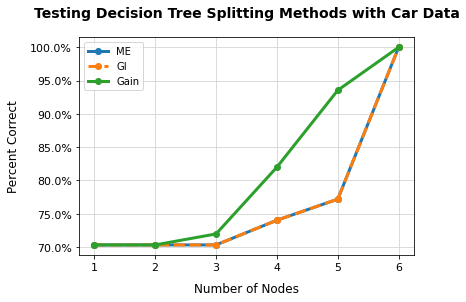

   Nodes        ME        GI      Gain
0      1  0.703297  0.703297  0.703297
1      2  0.703297  0.703297  0.703297
2      3  0.703297  0.703297  0.719780
3      4  0.740385  0.740385  0.820055
4      5  0.771978  0.771978  0.935440
5      6  1.000000  1.000000  1.000000


In [8]:
from matplotlib.ticker import PercentFormatter

# Car Decision Tree Data
number_of_nodes_car = np.arange(1, 7)
car_ME = np.array([512, 512, 512, 539, 562, 728]) / 728
car_GI = np.array([512, 512, 512, 539, 562, 728]) / 728
car_Gain = np.array([512, 512, 524, 597, 681, 728]) / 728

plt.plot(number_of_nodes_car, car_ME, '-o', linewidth = 3, label = 'ME')
plt.plot(number_of_nodes_car, car_GI, '--o', linewidth = 3, label = 'GI')
plt.plot(number_of_nodes_car, car_Gain, '-o', linewidth = 3, label = 'Gain')
plt.title('Testing Decision Tree Splitting Methods with Car Data', fontweight = 'bold', pad = 20, size = 14)
plt.xlabel('Number of Nodes', labelpad = 10, size = 12)
plt.xticks(size = 11)
plt.ylabel('Percent Correct', labelpad = 10, size = 12)
plt.yticks(size = 11)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.grid(True, color = 'lightgrey')
plt.legend()
plt.show()


df = pd.DataFrame()
df['Nodes'] = number_of_nodes_car
df['ME'] = car_ME
df['GI'] = car_GI
df['Gain'] = car_Gain
print(df)

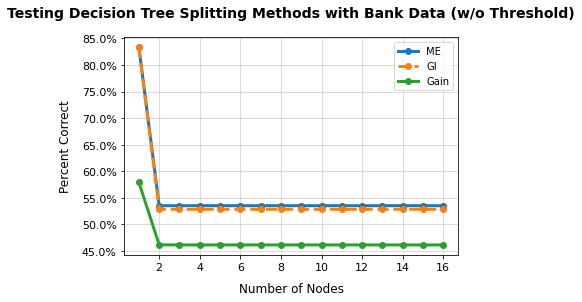

    Nodes      ME      GI    Gain
0       1  0.8334  0.8334  0.5792
1       2  0.5352  0.5284  0.4616
2       3  0.5352  0.5284  0.4614
3       4  0.5352  0.5284  0.4614
4       5  0.5352  0.5284  0.4614
5       6  0.5352  0.5284  0.4614
6       7  0.5352  0.5284  0.4614
7       8  0.5352  0.5284  0.4614
8       9  0.5352  0.5284  0.4614
9      10  0.5352  0.5284  0.4614
10     11  0.5352  0.5284  0.4614
11     12  0.5352  0.5284  0.4614
12     13  0.5352  0.5284  0.4614
13     14  0.5352  0.5284  0.4614
14     15  0.5352  0.5284  0.4614
15     16  0.5352  0.5284  0.4614


In [9]:
# Bank Decision Tree Data
# Without Rounding
number_of_nodes_bank = np.arange(1, 17)
bank_ME_without_rounding = np.array([4167, 2676, 2676, 2676, 2676, 2676, 2676, 2676, 2676, 2676, 2676, 2676, 2676, 2676, 2676, 2676]) / 5000
bank_GI_without_rounding = np.array([4167, 2642, 2642, 2642, 2642, 2642, 2642, 2642, 2642, 2642, 2642, 2642, 2642, 2642, 2642, 2642]) / 5000
bank_Gain_without_rounding = np.array([2896, 2308, 2307, 2307, 2307, 2307, 2307, 2307, 2307, 2307, 2307, 2307, 2307, 2307, 2307, 2307]) / 5000

plt.plot(number_of_nodes_bank, bank_ME_without_rounding, '-o', linewidth = 3, label = 'ME')
plt.plot(number_of_nodes_bank, bank_GI_without_rounding, '--o', linewidth = 3, label = 'GI')
plt.plot(number_of_nodes_bank, bank_Gain_without_rounding, '-o', linewidth = 3, label = 'Gain')
plt.title('Testing Decision Tree Splitting Methods with Bank Data (w/o Threshold)', fontweight = 'bold', pad = 20, size = 14)
plt.xlabel('Number of Nodes', labelpad = 10, size = 12)
plt.xticks(size = 11)
plt.ylabel('Percent Correct', labelpad = 10, size = 12)
plt.yticks(size = 11)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.grid(True, color = 'lightgrey')
plt.legend()
plt.show()


df = pd.DataFrame()
df['Nodes'] = number_of_nodes_bank
df['ME'] = bank_ME_without_rounding
df['GI'] = bank_GI_without_rounding
df['Gain'] = bank_Gain_without_rounding
print(df)

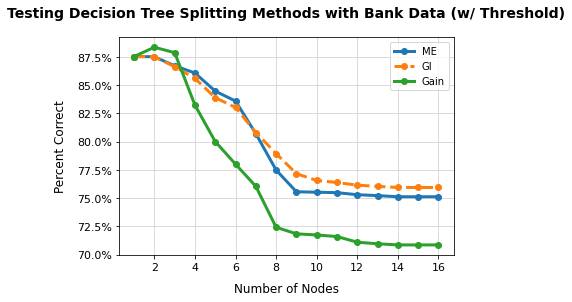

    Nodes      ME      GI    Gain
0       1  0.8752  0.8752  0.8752
1       2  0.8750  0.8750  0.8834
2       3  0.8670  0.8662  0.8786
3       4  0.8606  0.8558  0.8322
4       5  0.8446  0.8388  0.8000
5       6  0.8358  0.8302  0.7800
6       7  0.8070  0.8080  0.7604
7       8  0.7748  0.7894  0.7242
8       9  0.7556  0.7716  0.7184
9      10  0.7552  0.7656  0.7174
10     11  0.7548  0.7638  0.7160
11     12  0.7530  0.7614  0.7110
12     13  0.7522  0.7604  0.7096
13     14  0.7512  0.7594  0.7086
14     15  0.7512  0.7594  0.7086
15     16  0.7512  0.7594  0.7086


In [10]:
# Bank Decision Tree Data
# With Rounding
number_of_nodes_bank = np.arange(1, 17)
bank_ME_with_rounding = np.array([4376, 4375, 4335, 4303, 4223, 4179, 4035, 3874, 3778, 3776, 3774, 3765, 3761, 3756, 3756, 3756]) / 5000
bank_GI_with_rounding = np.array([4376, 4375, 4331, 4279, 4194, 4151, 4040, 3947, 3858, 3828, 3819, 3807, 3802, 3797, 3797, 3797]) / 5000
bank_Gain_with_rounding = np.array([4376, 4417, 4393, 4161, 4000, 3900, 3802, 3621, 3592, 3587, 3580, 3555, 3548, 3543, 3543, 3543]) / 5000

plt.plot(number_of_nodes_bank, bank_ME_with_rounding, '-o', linewidth = 3, label = 'ME')
plt.plot(number_of_nodes_bank, bank_GI_with_rounding, '--o', linewidth = 3, label = 'GI')
plt.plot(number_of_nodes_bank, bank_Gain_with_rounding, '-o', linewidth = 3, label = 'Gain')
plt.title('Testing Decision Tree Splitting Methods with Bank Data (w/ Threshold)', fontweight = 'bold', pad = 20, size = 14)
plt.xlabel('Number of Nodes', labelpad = 10, size = 12)
plt.xticks(size = 11)
plt.ylabel('Percent Correct', labelpad = 10, size = 12)
plt.yticks(size = 11)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.grid(True, color = 'lightgrey')
plt.legend()
plt.show()

df = pd.DataFrame()
df['Nodes'] = number_of_nodes_bank
df['ME'] = bank_ME_with_rounding
df['GI'] = bank_GI_with_rounding
df['Gain'] = bank_Gain_with_rounding
print(df)